In [66]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
from time import time
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from FER.utils import get_label
from sklearn.mixture import GaussianMixture

def dot(A,B): 
    return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity(a,b):
    return dot(a,b) / ( (dot(a,a) **.5) * (dot(b,b) ** .5) )

def cos_sim(a, b):
    sim = dot(a, b) / (norm(a) * norm(b))
    return sim


def window(seq_len, window_size=8, step_size=2):
    start = 0
    while (start + window_size) <= seq_len:
        end = start + window_size
        yield start, end
        start += step_size


def cor(x, y):
    r = np.corrcoef(x, y)
    return r[0, 1]


def norm(x):
    mean = np.mean(x)
    std = np.std(x)
    norm_x = (x - mean) / std
    return norm_x, mean, std


def stage1(x):
    y = []
    for td in x:
        m, s = np.mean(td), np.std(td)
        td[np.logical_and(td > (m - s), td < (m + s))] = 0
        y.append(np.true_divide(td.sum(1), (td != 0).sum(1)))
    y = np.stack(y, axis=0)
    y[np.isnan(y)] = 0
    return y


def stage1_v1(x):
    y = []
    for td in x:
        c = np.zeros((td.shape[0]))
        for ai, a in enumerate(td):
            m, s = np.mean(a), np.std(a)
            a[np.logical_and(a > (m - s), a < (m + s))] = 0
            c[ai] = np.true_divide(a.sum(0), (a != 0).sum(0))
        y.append(c)
    y = np.stack(y, axis=0)
    y[np.isnan(y)] = 0
    return y

def kl(u1, u2, s1, s2):
    return np.log(s2/s1) + (s1**2+(u1-u2)**2)/(2*s2**2) - 1/2



In [67]:
# train and test data
face_angle = 42
face_range_start, face_range_end = 42 - 4, 42 + 4

# get the data
root_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_v1"

# emotion_list = ['Joy', 'Surprise', 'Anger', 'Sadness', 'Fear', 'Disgust', 'Neutral']
emotion_list = ['Joy', 'Surprise', 'Anger', 'Sadness', 'Fear', 'Disgust']
start_index = 0
end_index = 9
npy_format = "{}_{}.npy"

# Train data
train_data = []
train_label = []

for e in emotion_list:
    for i in range(start_index, end_index):
        bin_path = os.path.join(root_dir, npy_format.format(e, i))
        if not os.path.exists(bin_path):
            continue
        npy_data = np.load(bin_path)
        npy_label = get_label(e)
        train_data.append(npy_data[face_range_start:face_range_end])
        train_label.append(npy_label)
train_data = np.stack(train_data, axis=0)
Y_train = np.asarray(train_label)

# Test data
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_stand"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_Nancy"
test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_v1"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_ground"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_stand"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_stand_v1"
test_data_path = os.path.join(test_dir, npy_format.format('Joy', 1))
test_npy = np.load(test_data_path)
seq_len, w = test_npy.shape
ws = 8
overlap = 1

test_data = np.zeros(((seq_len - ws) // overlap + 1, ws, 300))

t_index = 0
for s, e in window(seq_len, ws, overlap):
    test_data[t_index] = test_npy[s:e]
    t_index += 1

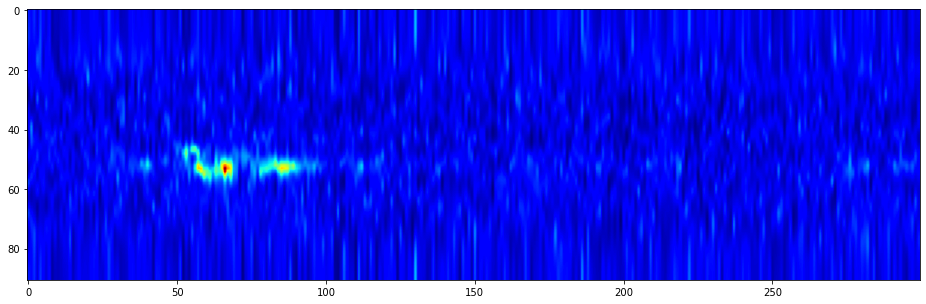

In [68]:
# plot test data
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_stand_v1"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_1m_Nancy"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Standing_Nancy"
# test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Ground_Nancy"
test_dir = "C:\\Users\\Zber\\Desktop\\Capon_Heatmap\\Distance_100cm_Nancy"

test_data_path = os.path.join(test_dir, npy_format.format('Joy',2))
test_npy = np.load(test_data_path)
fig1, axes1 = plt.subplots(1, 1, figsize=(16, 9))
# axes1.imshow(test_npy[:, 30:150], cmap=plt.cm.jet)
axes1.imshow(test_npy[:, :], cmap=plt.cm.jet)

In [69]:
seq_len, w = test_npy.shape
ws = 8
overlap = 1

test_data = np.zeros(((seq_len - ws) // overlap + 1, ws, 300))

t_index = 0
for s, e in window(seq_len, ws, overlap):
    test_data[t_index] = test_npy[s:e]
    t_index += 1

In [70]:
# 1. normalization
train_data, mean, std = norm(train_data)
test_data = (test_data - mean) / std

In [57]:
# pca dimention reduction
# n_components = 5
# pca = PCA(n_components=n_components, svd_solver="auto", whiten=False).fit(X_train)

train_data.shape

(42, 8, 300)

In [71]:
# mix gmm fitting
# gm = GaussianMixture(n_components=2, random_state=0, means_init=[[-0.37],[0.82]]).fit(train_data[:7, 3:6].reshape(-1, 1))
# gm = GaussianMixture(n_components=3, random_state=0, means_init=[[-0.37],[0.82],[0.9]]).fit(train_data[:7, 3:6].reshape(-1, 1))


In [59]:
# gm = GaussianMixture(covariance_type="spherical", n_components=2, random_state=0, means_init=[[-0.37],[0.82]]).fit(train_data[:7, 3:6].reshape(-1, 1))

In [60]:
# Density Estimation

In [61]:
# gm = GaussianMixture(n_components=2, random_state=0, means_init=[[-0.37],[0.82]]).fit(train_data[:, 5].reshape(-1, 1))

In [72]:
print(gm.means_)
print()

# m1,m2,m3 = gm.means_.reshape(-1)
# s1,s2,s3 = gm.covariances_.reshape(-1)

print(gm.covariances_)
print()

print(gm.weights_)
print(type(gm.weights_))

[[-0.60846761]
 [ 1.02683433]
 [ 0.24935057]]

[[[0.22852449]]

 [[1.65078061]]

 [[0.27367733]]]

[0.43362842 0.12432148 0.4420501 ]
<class 'numpy.ndarray'>


In [73]:


res_data = []
tt_m1 = []
tt_m2 = []
tt_s1 = []
tt_s2 = []

p0=[]
p1=[]
p2=[]
tpp = []


for i in range(len(test_data)):

    # res = gm.predict(test_data[i, 3:6].reshape(-1,1))
    res = gm.predict(test_data[i, :].reshape(-1,1))
    res_pp = get_prob(res, n_comp)
    # res_p0 = len(res[res==0])/len(res)
    # res_p1 = len(res[res==1])/len(res)
    # res_p2 = len(res[res==2])/len(res)
    # print(res_p0)
    # print(res_p1)
    # print(res_p2)
    # res_pp = np.asarray([res_p0, res_p1, res_p2])

    # print(res_pp)
    # res_data.append(np.sum(res)/len(res))
    res = cosine_similarity(a=gm.weights_, b=res_pp)

    # res_data.append(res_p1)
    res_data.append(res)
    tpp.append(res_pp)
    # p0.append(res_p0)
    # p1.append(res_p1)
    # p2.append(res_p2)

    # res = gm.predict(test_data[i, 3:6].reshape(-1,1))
    # gm_test = GaussianMixture(n_components=2, random_state=0, means_init=[[-0.37],[0.82]]).fit(test_data[i, 3:6].reshape(-1,1))
    # t_m1, t_m2 = gm_test.means_.reshape(-1)
    # t_s1, t_s2 = gm_test.covariances_.reshape(-1) 
    # tt_m1.append(t_m1)
    # tt_m2.append(t_m2)
    # tt_s1.append(t_s1)
    # tt_s2.append(t_s2)
    # res = 1/( 0.7*  kl(m2, t_m2, s2, t_s2)  +0.3*kl(m1, t_m1, s1, t_s1))
    # res_data.append(res)

In [64]:
# cosine_similarity([1,2,3] , [2,3,4])

Text(0.5, 0, 'Angle')

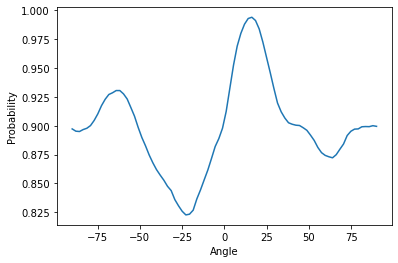

In [74]:
# %matplotlib widget
plt.close()
x = np.linspace(-90, 90, len(res_data))
plt.plot(x, res_data)
plt.ylabel("Probability")
plt.xlabel("Angle")

ValueError: x and y must have same first dimension, but have shapes (84,) and (0,)

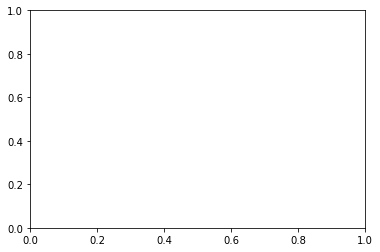

In [51]:
plt.plot(x, tt_m1, label="m1")
plt.plot(x, tt_m2, label="m2")
plt.plot(x, tt_s1, label="s1")
plt.plot(x, tt_s2, label="s2")
plt.legend()
plt.show()

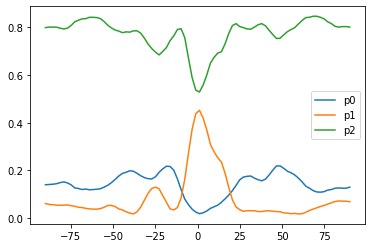

In [ ]:
plt.plot(x, p0, label="p0")
plt.plot(x, p1, label="p1")
plt.plot(x, p2, label="p2")
# plt.plot(x, tt_s2, label="s2")
plt.legend()
plt.show()

$KL(p, q) = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$